In [0]:
%matplotlib inline

# Multi layer perceptron from scratch - MNIST dataset

**Reference:** https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9

A neural network needs a few building blocks

- Dense layer - a fully-connected layer, $f(X)=W \cdot X + \vec{b}$
- ReLU layer (activation function to introduce non-linearity)
- Loss function (crossentropy in case of multi-class classification problem)
- Backprop algorithm - a stochastic gradient descent with backpropageted gradients

Let's approach them one at a time.

Let's start by importing some libraires required for creating our neural network.

In [0]:
from __future__ import print_function
import numpy as np ## For numerical python
np.random.seed(42)

Every layer will have a forward pass and backpass implementation. Let's create a main class layer which can do a forward pass .forward() and Backward pass .backward().

In [0]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:

    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here we can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, we need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, we already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If our layer has parameters (e.g. dense layer), we also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

### Nonlinearity ReLU layer

This is the simplest layer you can get: it simply applies a nonlinearity to each element of your network.

In [0]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        relu_forward = np.maximum(0,input)
        return relu_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad 

### Dense layer

Now let's build something more complicated. Unlike nonlinearity, a dense layer actually has something to learn.

A dense layer applies affine transformation. In a vectorized form, it can be described as:
$$f(X)= W \cdot X + \vec b $$

Where 
* X is an object-feature matrix of shape [batch_size, num_features],
* W is a weight matrix [num_features, num_outputs] 
* and b is a vector of num_outputs biases.

Both W and b are initialized during layer creation and updated each time backward is called. Note that we are using **Xavier initialization** which is a trick to train our model to converge faster [read more](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization). Instead of initializing our weights with small numbers which are distributed randomly we initialize our weights with mean zero and variance of 2/(number of inputs + number of outputs)

In [0]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(2/(input_units+output_units)), 
                                        size = (input_units,output_units))
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input,self.weights) + self.biases
    
    def backward(self,input,grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

### The loss function

Since we want to predict probabilities, it would be logical for us to define softmax nonlinearity on top of our network and compute loss given predicted probabilities. However, there is a better way to do so.

If we write down the expression for crossentropy as a function of softmax logits (a), you'll see:

$$ loss = - log \space {e^{a_{correct}} \over {\underset i \sum e^{a_i} } } $$

If we take a closer look, we'll see that it can be rewritten as:

$$ loss = - a_{correct} + log {\underset i \sum e^{a_i} } $$

It's called Log-softmax and it's better than naive log(softmax(a)) in all aspects:
* Better numerical stability
* Easier to get derivative right
* Marginally faster to compute

So why not just use log-softmax throughout our computation and never actually bother to estimate probabilities.

In [0]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

### Full network

Now let's combine what we've just built into a working neural network. We are going to use MNIST data of handwritten digit for our example. Fortunately, Keras already have it in the numpy array format, so let's import it!.

Using TensorFlow backend.


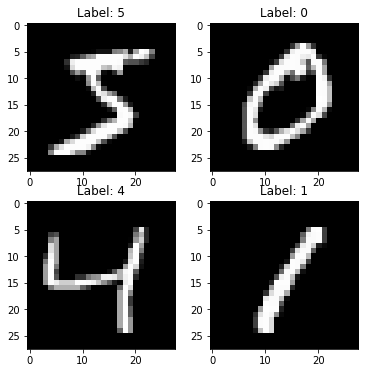

In [7]:
import keras
import matplotlib.pyplot as plt
%matplotlib inline

def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

## Let's look at some example
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

We'll define network as a list of layers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial.

In [0]:
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))

In [0]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    """
    activations = []
    input = X

    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions. Returning indices of largest Logit probability
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    """
    Train our network on a given batch of X and y.
    We first need to run forward to get all layer activations.
    Then we can run layer.backward going from last to first layer.
    After we have called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)

### Training loop

We split data into minibatches, feed each such minibatch into the network and update weights. This training method is called a mini-batch stochastic gradient descent.

In [0]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [0]:
def get_network(input_units, output_units, learning_rate=0.1, epochs=25, dense_output_units=[100, 200], print_network=False):
    if print_network:
        print('\tNETWORK: Multi layer perceptron')
    network = []
    network.append(Dense(input_units, dense_output_units[0], learning_rate))
    if print_network:
        print('\t\tDense(input_units={}, output_units={}, learning_rate={})'.format(input_units, dense_output_units[0], learning_rate))
    network.append(ReLU())
    if print_network:
        print('\t\tReLU()')
    
    for i, _ in enumerate(dense_output_units):
      if i == len(dense_output_units) - 1:
        break
      network.append(Dense(dense_output_units[i], dense_output_units[i+1], learning_rate))
      if print_network:
          print('\t\tDense(input_units={}, output_units={}, learning_rate={})'.format(dense_output_units[i], dense_output_units[i+1], learning_rate))
      network.append(ReLU())
      if print_network:
          print('\t\tReLU()')
    
    network.append(Dense(dense_output_units[-1], output_units))
    if print_network:
        print('\t\tDense(input_units={}, output_units={}, learning_rate={})'.format(dense_output_units[-1], output_units, learning_rate))

    return network

In [0]:
from IPython.display import clear_output
from time import time

def training_loop(network, input_units, output_units, learning_rate=0.1, epochs=25, dense_output_units=[100, 200], batchsize=32, shuffle=True):
    if len(dense_output_units) < 2:
      return

    epoch_start = time()
    train_acc_list = []
    val_acc_list = []
    epoch_time_list = []

    last_train_accuracy = 0.0
    last_validation_accuracy = 0.0

    for epoch in range(epochs):

        for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=batchsize,shuffle=shuffle):
            train(network,x_batch,y_batch)
        
        train_acc_list.append(np.mean(predict(network,X_train)==y_train))
        val_acc_list.append(np.mean(predict(network,X_val)==y_val))
        
        clear_output()
        print("Epoch", epoch)
        print("Training accuracy: {:.2f}%".format(train_acc_list[-1]*100))
        print("Validation accuracy: {:.2f}%".format(val_acc_list[-1]*100))
        epoch_time = time() - epoch_start
        epoch_time_list.append(epoch_time)
        print("Epoch's processing time: {:.2f} seconds".format(epoch_time))
        plt.plot(train_acc_list, label='train accuracy')
        plt.plot(val_acc_list, label='val accuracy')
        plt.legend(loc='best')
        plt.grid()
        plt.show()
    
    return train_acc_list, val_acc_list, epoch_time_list

## Testing different dense layers

* Using 2 dense layers with learning_rate=0.1 (100 and 200 output units). Minibatches: batchsize=32, shuffle=True

* Using 3 dense layers with learning_rate=0.1 (100, 200, and 300 output units). Minibatches: batchsize=32, shuffle=True

* Using 4 dense layers with learning_rate=0.1 (100, 200, 300 and 400 output units). Minibatches: batchsize=32, shuffle=True

* Using 5 dense layers with learning_rate=0.1 (100, 200, 300, 400, and 500 output units). Minibatches: batchsize=32, shuffle=True

In [0]:
validation_accuracy_list = []

In [0]:
from time import time
import numpy as np

def mlp_training(network, input_units, output_units, learning_rate, epochs, dense_output_units, batchsize, shuffle):
    training_start = time()
    train_acc_list, val_acc_list, epoch_time_list = training_loop(network, input_units=input_units, output_units=output_units, learning_rate=learning_rate, epochs=epochs, dense_output_units=dense_output_units, batchsize=batchsize, shuffle=shuffle)
    print("Total time: {} seconds".format(time() - training_start))

    labels = ['epoch {}'.format(str(i).zfill(3)) for i in range(epochs)]

    train_acc_np = np.asarray(train_acc_list)
    print("\nTraining accuracy list: {}".format(train_acc_np))
    print("Training accuracy (Mean +/- Std): %0.2f (+/- %0.2f)" % (train_acc_np.mean()*100, train_acc_np.std() * 2))
    # Plot horizontal bar
    values = [v * 100 for v in train_acc_list]
    plot_horizontal_bar(labels, values, xlabel='Accuracy', ylabel='', title='Training accuracy per epoch', use_xlim=True)

    val_acc_np = np.asarray(val_acc_list)
    print("\nValidation accuracy list: {}".format(val_acc_np))
    print("Validation accuracy (Mean +/- Std): %0.2f (+/- %0.2f)" % (val_acc_np.mean()*100, val_acc_np.std() * 2))

    # Save validation accuracy to plotting: Validation accuracy Vs Number of dense layers
    validation_accuracy_list.append(val_acc_np.mean()*100)

    # Plot horizontal bar
    values = [v * 100 for v in val_acc_list]
    plot_horizontal_bar(labels, values, xlabel='Accuracy', ylabel='', title='Validation accuracy per epoch', use_xlim=True)

    epoch_time_np = np.asarray(epoch_time_list)
    print("\nEpoch time list: {}".format(epoch_time_np))
    print("Epoch time (Mean +/- Std): %0.2f (+/- %0.2f)" % (epoch_time_np.mean(), epoch_time_np.std() * 2))
    # Plot horizontal bar
    values = [v * 100 for v in epoch_time_list]
    plot_horizontal_bar(labels, values, xlabel='Time', ylabel='', title='Epoch time in seconds', use_xlim=False)

In [0]:
def plot_horizontal_bar(x, y, xlabel, ylabel, title, use_xlim=False):
    fig, ax = plt.subplots()    
    width = 0.75 # the width of the bars 
    ind = np.arange(len(y))  # the x locations for the groups
    ax.barh(ind, y, width, color="blue")
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(x, minor=False)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    for i, v in enumerate(y):
        ax.text(v + 3, i + .25, '%0.2f'%(v), color='blue', fontweight='bold')
    
    if use_xlim:
        plt.xlim(0, 120)
        plt.tight_layout()
    
    plt.show()

### Using **2 dense layers** (100 and 200 output units) with learning_rate=0.1 . Minibatches: batchsize=32, shuffle=True

In [16]:
dense_output_units=[100, 200]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		ReLU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		ReLU()
		Dense(input_units=200, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 100.00%
Validation accuracy: 98.06%
Epoch's processing time: 135.62 seconds


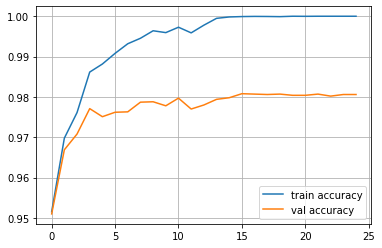

Total time: 135.80966591835022 seconds

Training accuracy list: [0.95156 0.96978 0.97612 0.98616 0.98816 0.9908  0.99318 0.99454 0.9964
 0.99594 0.99728 0.99588 0.99778 0.99948 0.99982 0.99992 0.99996 0.99994
 0.9999  1.      0.99998 1.      1.      1.      1.     ]
Training accuracy (Mean +/- Std): 99.33 (+/- 0.02)


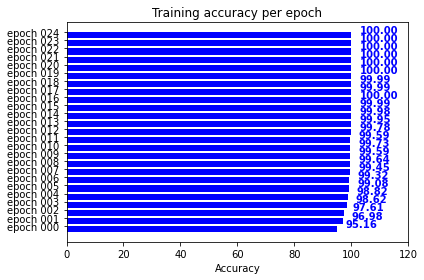


Validation accuracy list: [0.951  0.9669 0.9708 0.9771 0.9751 0.9762 0.9763 0.9787 0.9788 0.9778
 0.9797 0.977  0.978  0.9794 0.9798 0.9808 0.9807 0.9806 0.9807 0.9804
 0.9804 0.9807 0.9802 0.9806 0.9806]
Validation accuracy (Mean +/- Std): 97.71 (+/- 0.01)


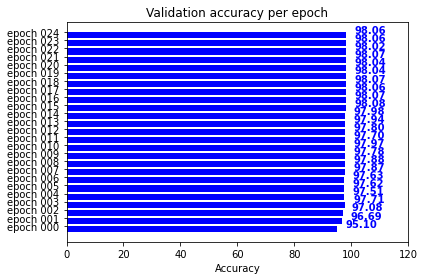


Epoch time list: [  5.20242405  10.60275912  15.84133863  21.25806212  26.60969114
  31.95669603  37.36366439  42.76565671  48.25063753  53.58064365
  59.03114748  64.39981055  69.83130026  75.13312745  80.48183775
  85.99083161  91.63675809  97.1125021  102.63477063 108.14703631
 113.66325831 119.21756887 124.67078757 130.14429474 135.6190927 ]
Epoch time (Mean +/- Std): 70.05 (+/- 78.41)


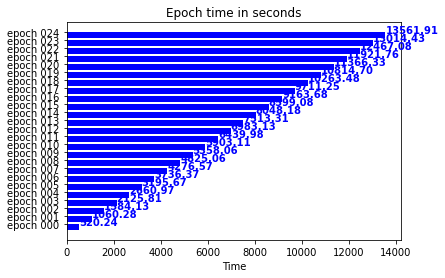

In [17]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using **3 dense layers** (100, 200 and 300 output units) with learning_rate=0.1 . Minibatches: batchsize=32, shuffle=True

In [18]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		ReLU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		ReLU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		ReLU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 100.00%
Validation accuracy: 98.19%
Epoch's processing time: 209.08 seconds


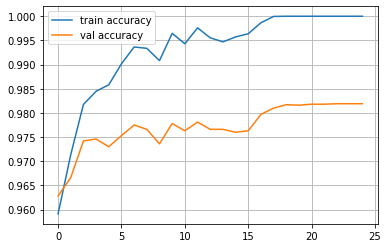

Total time: 209.45817160606384 seconds

Training accuracy list: [0.9591  0.97134 0.98174 0.98448 0.98582 0.99016 0.99364 0.99336 0.99082
 0.99646 0.9943  0.9976  0.99554 0.9947  0.99572 0.99638 0.99866 0.99996
 1.      1.      1.      1.      1.      1.      1.     ]
Training accuracy (Mean +/- Std): 99.28 (+/- 0.02)


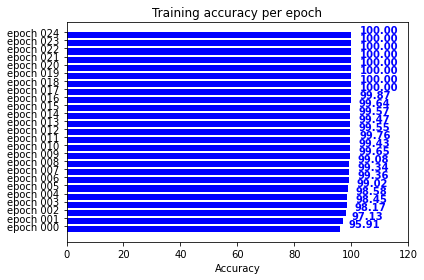


Validation accuracy list: [0.9628 0.9666 0.9742 0.9746 0.973  0.9753 0.9775 0.9766 0.9736 0.9778
 0.9763 0.9781 0.9766 0.9766 0.976  0.9763 0.9797 0.981  0.9817 0.9816
 0.9818 0.9818 0.9819 0.9819 0.9819]
Validation accuracy (Mean +/- Std): 97.70 (+/- 0.01)


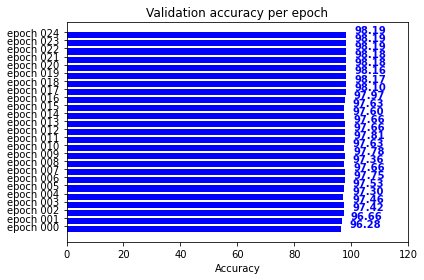


Epoch time list: [  8.29154372  16.63913465  24.9513123   33.30167675  41.64178586
  49.92482901  57.99924016  66.17330885  74.32762814  82.55788088
  90.92968702  99.21053553 107.80012202 116.38110733 124.83239651
 133.22338915 141.63520479 150.14378214 158.72716904 167.10729647
 175.46060443 183.91401434 192.34439802 200.68140817 209.07996368]
Epoch time (Mean +/- Std): 108.29 (+/- 120.76)


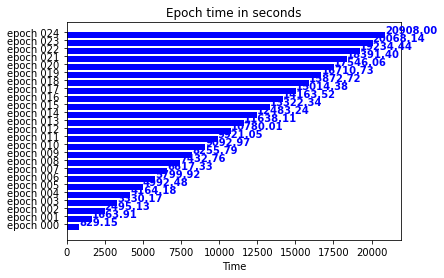

In [19]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using **4 dense layers** (100, 200, 300 and 400 output units) with learning_rate=0.1 . Minibatches: batchsize=32, shuffle=True

In [20]:
dense_output_units=[100, 200, 300, 400]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		ReLU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		ReLU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		ReLU()
		Dense(input_units=300, output_units=400, learning_rate=0.1)
		ReLU()
		Dense(input_units=400, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 100.00%
Validation accuracy: 98.03%
Epoch's processing time: 348.09 seconds


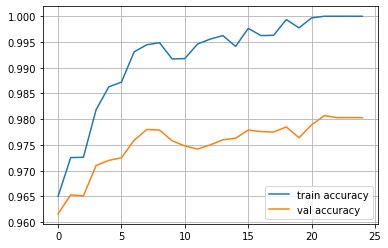

Total time: 348.2948594093323 seconds

Training accuracy list: [0.96502 0.97254 0.9726  0.98184 0.98628 0.9872  0.99308 0.99446 0.99486
 0.9917  0.99178 0.9946  0.99556 0.99624 0.99414 0.99764 0.99624 0.9963
 0.99936 0.99774 0.99968 1.      1.      1.      1.     ]
Training accuracy (Mean +/- Std): 99.20 (+/- 0.02)


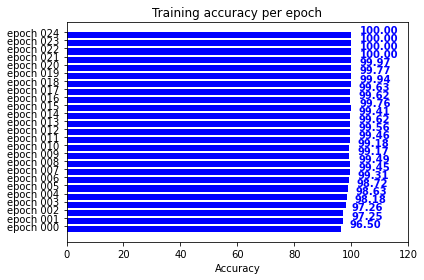


Validation accuracy list: [0.9616 0.9653 0.9651 0.971  0.972  0.9725 0.9759 0.978  0.9779 0.9758
 0.9748 0.9742 0.975  0.976  0.9763 0.9779 0.9776 0.9775 0.9785 0.9764
 0.9789 0.9807 0.9803 0.9803 0.9803]
Validation accuracy (Mean +/- Std): 97.52 (+/- 0.01)


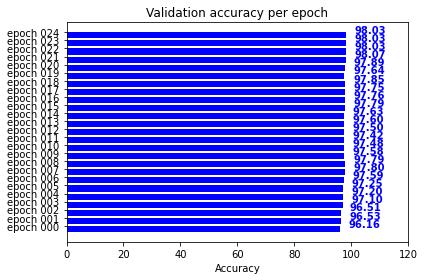


Epoch time list: [ 14.70045352  31.28847814  45.14705372  59.01889825  72.83976865
  86.62718964 100.41452765 114.45773005 128.17825794 142.06548309
 155.44275928 169.08612132 182.65289712 196.26362896 209.70398521
 223.51095033 237.12026286 251.06379032 265.06931114 278.79627657
 292.37280059 306.12259793 320.06259036 333.83932877 348.085464  ]
Epoch time (Mean +/- Std): 182.56 (+/- 198.48)


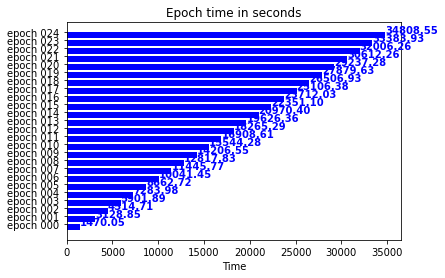

In [21]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using **5 dense layers** (100, 200, 300, 400 and 500 output units) with learning_rate=0.1 . Minibatches: batchsize=32, shuffle=True

In [22]:
dense_output_units=[100, 200, 300, 400, 500]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		ReLU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		ReLU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		ReLU()
		Dense(input_units=300, output_units=400, learning_rate=0.1)
		ReLU()
		Dense(input_units=400, output_units=500, learning_rate=0.1)
		ReLU()
		Dense(input_units=500, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 99.58%
Validation accuracy: 97.67%
Epoch's processing time: 543.70 seconds


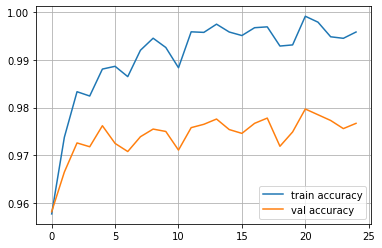

Total time: 543.898157119751 seconds

Training accuracy list: [0.95774 0.97378 0.98332 0.98242 0.98806 0.98864 0.98648 0.992   0.99452
 0.99258 0.98834 0.99586 0.99574 0.99746 0.99582 0.99508 0.99672 0.9969
 0.99288 0.99312 0.99912 0.99788 0.99482 0.9945  0.99582]
Training accuracy (Mean +/- Std): 99.08 (+/- 0.02)


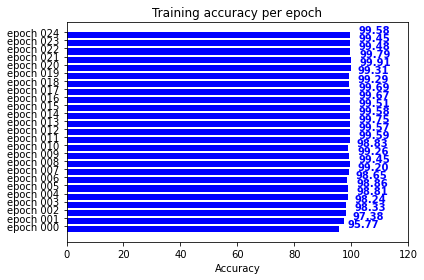


Validation accuracy list: [0.9582 0.9665 0.9726 0.9718 0.9762 0.9725 0.9708 0.9739 0.9755 0.975
 0.9711 0.9758 0.9765 0.9776 0.9754 0.9746 0.9767 0.9778 0.9719 0.9749
 0.9797 0.9785 0.9773 0.9756 0.9767]
Validation accuracy (Mean +/- Std): 97.41 (+/- 0.01)


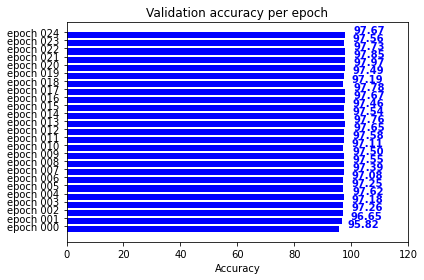


Epoch time list: [ 21.74100351  43.59457016  65.43932247  87.17366195 108.63294959
 129.53862238 151.73835325 173.71815562 195.46007967 217.22574806
 238.91697216 260.36323404 285.84313011 307.51233864 329.04434562
 350.54143453 371.73714447 393.44259667 414.93548059 436.28457689
 457.69113541 479.37564564 500.6542654  522.29417729 543.70399094]
Epoch time (Mean +/- Std): 283.46 (+/- 314.65)


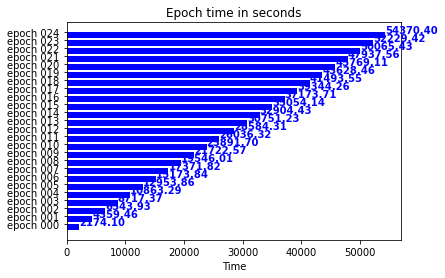

In [23]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

## Best number of dense layers

* Highest validation accuracy (mean)

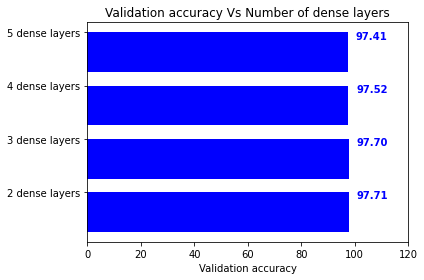

In [24]:
labels = ['2 dense layers', '3 dense layers', '4 dense layers', '5 dense layers']
plot_horizontal_bar(labels, validation_accuracy_list, xlabel='Validation accuracy', ylabel='', title='Validation accuracy Vs Number of dense layers', use_xlim=True)

In [0]:
validation_accuracy_list = []

## Testing different learning rates

* Using 3 dense layers with learning_rate = 0.1. Minibatches: batchsize=32, shuffle=True

* Using 3 dense layers with learning_rate = 0.01. Minibatches: batchsize=32, shuffle=True

* Using 3 dense layers with learning_rate = 0.001. Minibatches: batchsize=32, shuffle=True

* Using 3 dense layers with learning_rate = 0.0001. Minibatches: batchsize=32, shuffle=True

In [26]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		ReLU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		ReLU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		ReLU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


### Using 3 dense layers with **learning_rate = 0.1**. Minibatches: batchsize=32, shuffle=True

Epoch 24
Training accuracy: 100.00%
Validation accuracy: 98.18%
Epoch's processing time: 210.60 seconds


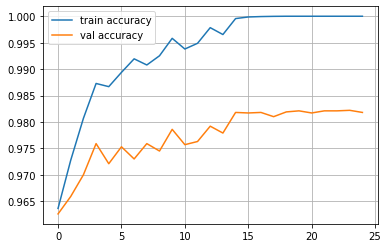

Total time: 210.8048803806305 seconds

Training accuracy list: [0.96364 0.97276 0.98068 0.98728 0.98668 0.98938 0.99194 0.99078 0.99252
 0.99582 0.9938  0.99488 0.99784 0.99654 0.99956 0.99986 0.99994 0.99998
 1.      1.      1.      1.      1.      1.      1.     ]
Training accuracy (Mean +/- Std): 99.34 (+/- 0.02)


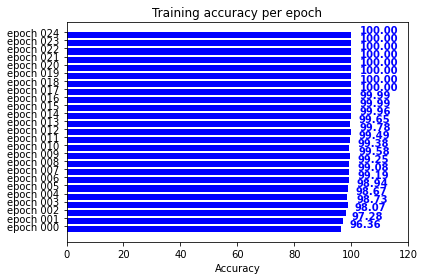


Validation accuracy list: [0.9626 0.9659 0.97   0.9759 0.9721 0.9753 0.973  0.9759 0.9745 0.9786
 0.9757 0.9763 0.9792 0.9779 0.9818 0.9817 0.9818 0.981  0.9819 0.9821
 0.9817 0.9821 0.9821 0.9822 0.9818]
Validation accuracy (Mean +/- Std): 97.73 (+/- 0.01)


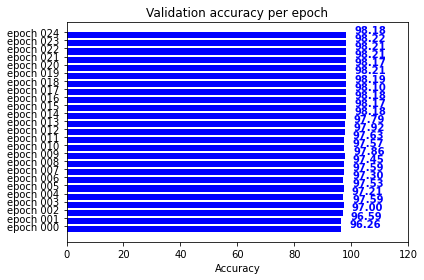


Epoch time list: [  7.96670938  16.49691772  24.9906683   33.42649579  41.94872904
  50.21869016  58.4494648   66.93908763  75.64651561  84.02737141
  92.23159099 100.60254407 109.06083989 117.55794096 125.87829494
 134.39863086 142.90104795 151.3411901  159.95355439 168.38288474
 176.84568858 185.36870646 193.82988334 202.26508689 210.60421896]
Epoch time (Mean +/- Std): 109.25 (+/- 121.73)


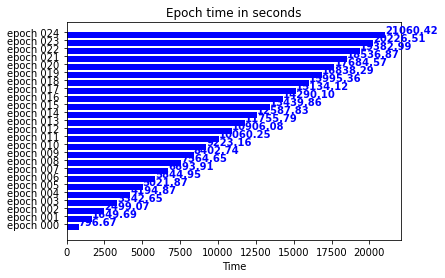

In [27]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 3 dense layers with **learning_rate = 0.01**. Minibatches: batchsize=32, shuffle=True

Epoch 24
Training accuracy: 100.00%
Validation accuracy: 98.12%
Epoch's processing time: 214.56 seconds


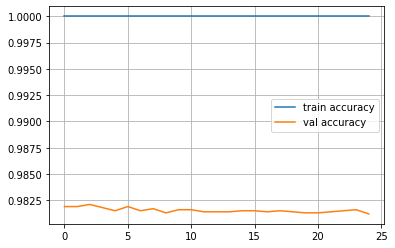

Total time: 214.75555539131165 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


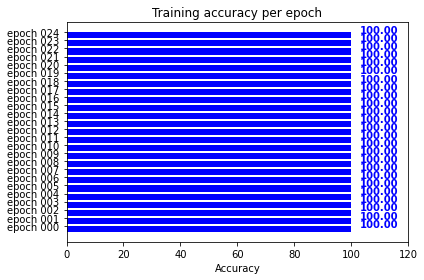


Validation accuracy list: [0.9819 0.9819 0.9821 0.9818 0.9815 0.9819 0.9815 0.9817 0.9813 0.9816
 0.9816 0.9814 0.9814 0.9814 0.9815 0.9815 0.9814 0.9815 0.9814 0.9813
 0.9813 0.9814 0.9815 0.9816 0.9812]
Validation accuracy (Mean +/- Std): 98.15 (+/- 0.00)


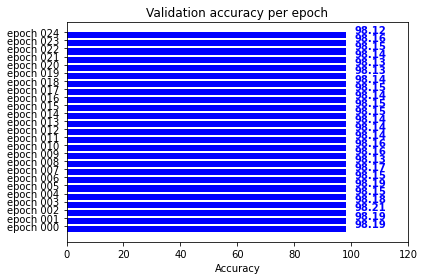


Epoch time list: [  8.40516186  16.89273906  25.34194946  33.77901554  42.15053749
  50.70171905  59.06740928  67.82577586  76.31908512  84.944736
  93.44298005 101.73667216 110.08171749 118.38609838 127.63880897
 138.8057785  147.02783823 155.30683708 163.86287951 172.35548234
 181.01757026 189.51725578 197.8164649  206.01217175 214.55647731]
Epoch time (Mean +/- Std): 111.32 (+/- 124.69)


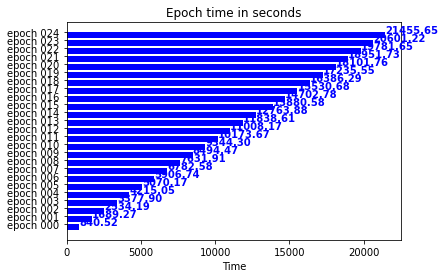

In [28]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.01, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 3 dense layers with **learning_rate = 0.001**. Minibatches: batchsize=32, shuffle=True

Epoch 24
Training accuracy: 100.00%
Validation accuracy: 98.13%
Epoch's processing time: 210.33 seconds


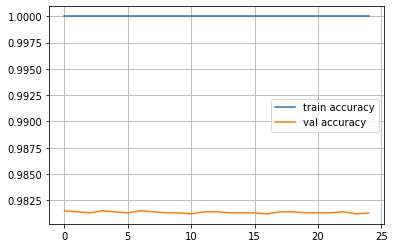

Total time: 210.53559231758118 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


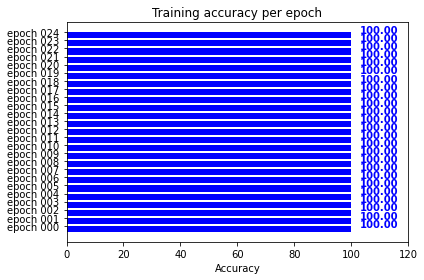


Validation accuracy list: [0.9815 0.9814 0.9813 0.9815 0.9814 0.9813 0.9815 0.9814 0.9813 0.9813
 0.9812 0.9814 0.9814 0.9813 0.9813 0.9813 0.9812 0.9814 0.9814 0.9813
 0.9813 0.9813 0.9814 0.9812 0.9813]
Validation accuracy (Mean +/- Std): 98.13 (+/- 0.00)


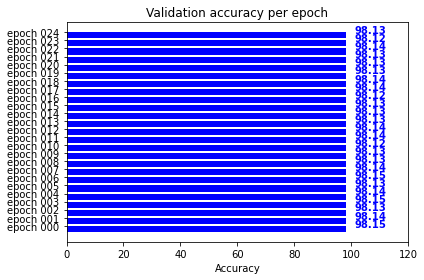


Epoch time list: [  8.2185483   16.63572288  25.1079998   33.49598932  41.88031912
  50.0026083   58.35921121  66.79417062  75.05078745  83.35277772
  91.42772031 100.01449776 108.77267408 117.12674856 125.42153406
 134.03130221 142.5667398  150.91566539 159.48975849 167.96354556
 176.44759583 184.9426887  193.51064825 201.9773736  210.33002138]
Epoch time (Mean +/- Std): 108.95 (+/- 121.46)


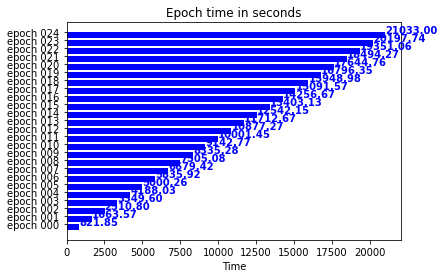

In [29]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 3 dense layers with **learning_rate = 0.0001**. Minibatches: batchsize=32, shuffle=True

Epoch 24
Training accuracy: 100.00%
Validation accuracy: 98.13%
Epoch's processing time: 207.05 seconds


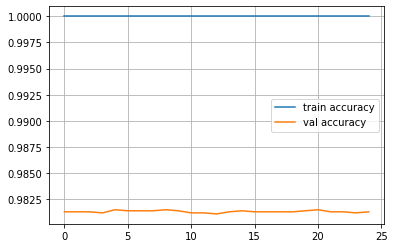

Total time: 207.25969243049622 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


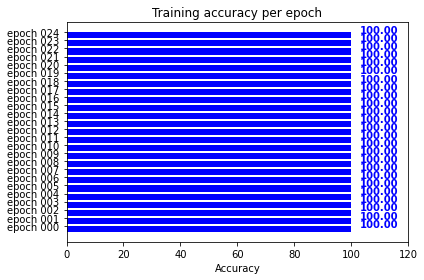


Validation accuracy list: [0.9813 0.9813 0.9813 0.9812 0.9815 0.9814 0.9814 0.9814 0.9815 0.9814
 0.9812 0.9812 0.9811 0.9813 0.9814 0.9813 0.9813 0.9813 0.9813 0.9814
 0.9815 0.9813 0.9813 0.9812 0.9813]
Validation accuracy (Mean +/- Std): 98.13 (+/- 0.00)


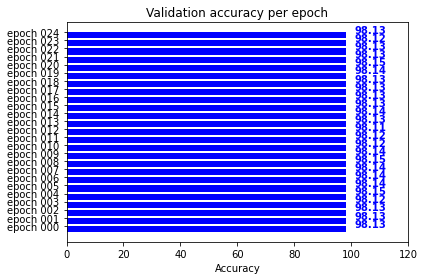


Epoch time list: [  7.80921173  16.01034832  24.18605971  32.39347029  40.67172599
  49.05038428  57.41626811  65.72239614  73.92879176  82.05980468
  90.53885341  98.89387989 107.48685336 115.90228128 124.38392639
 132.83169389 141.09556079 149.37143755 157.66547871 166.02656865
 174.28830004 182.56078672 190.73538661 198.92015457 207.05456257]
Epoch time (Mean +/- Std): 107.48 (+/- 120.18)


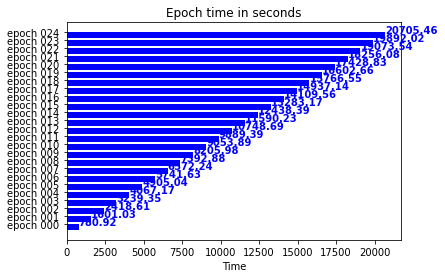

In [30]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.0001, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

## Best learning rate

* Highest validation accuracy (mean)

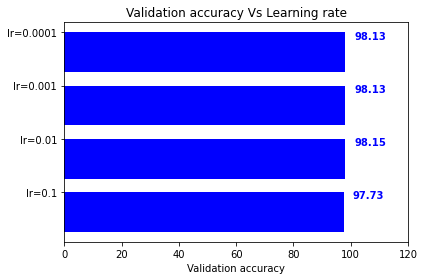

In [31]:
labels = ['lr=0.1', 'lr=0.01', 'lr=0.001', 'lr=0.0001']
plot_horizontal_bar(labels, validation_accuracy_list, xlabel='Validation accuracy', ylabel='', title='Validation accuracy Vs Learning rate', use_xlim=True)

In [0]:
validation_accuracy_list = []

## Testing different batch size

* Using 3 dense layers with learning_rate = 0.001. Minibatches: batchsize=8, shuffle=True

* Using 3 dense layers with learning_rate = 0.001. Minibatches: batchsize=16, shuffle=True

* Using 3 dense layers with learning_rate = 0.001. Minibatches: batchsize=32, shuffle=True

* Using 3 dense layers with learning_rate = 0.001. Minibatches: batchsize=64, shuffle=True

* Using 3 dense layers with learning_rate = 0.001. Minibatches: batchsize=128, shuffle=True

In [33]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		ReLU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		ReLU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		ReLU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


### Using 3 dense layers with learning_rate = 0.001. Minibatches: **batchsize=8**, shuffle=True

Epoch 24
Training accuracy: 99.70%
Validation accuracy: 97.76%
Epoch's processing time: 449.46 seconds


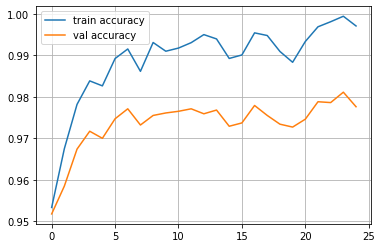

Total time: 449.6591064929962 seconds

Training accuracy list: [0.95336 0.9675  0.97816 0.98382 0.98262 0.9892  0.9915  0.98612 0.99306
 0.99096 0.99172 0.99302 0.99496 0.99392 0.98922 0.99006 0.99538 0.99474
 0.9909  0.9883  0.9933  0.99684 0.99806 0.99938 0.99704]
Training accuracy (Mean +/- Std): 98.89 (+/- 0.02)


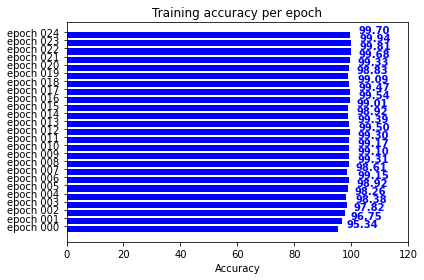


Validation accuracy list: [0.9518 0.9585 0.9674 0.9717 0.97   0.9747 0.9771 0.9732 0.9755 0.9761
 0.9765 0.9771 0.9759 0.9768 0.9729 0.9737 0.9779 0.9755 0.9734 0.9727
 0.9746 0.9788 0.9786 0.9811 0.9776]
Validation accuracy (Mean +/- Std): 97.36 (+/- 0.01)


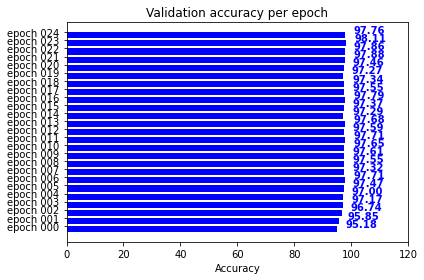


Epoch time list: [ 18.21149087  36.94545007  55.91951823  74.910815    92.61470699
 116.11590552 133.56134391 151.08497143 168.95934463 186.43234944
 204.09750104 221.55481887 238.96703386 256.53704119 273.91783357
 291.63111496 309.30195999 326.91513133 344.45371175 361.92504549
 379.63963318 396.95813489 414.43915582 431.9421463  449.45774269]
Epoch time (Mean +/- Std): 237.46 (+/- 257.61)


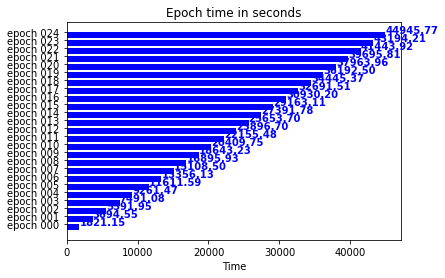

In [34]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=8, shuffle=True)

### Using 3 dense layers with learning_rate = 0.001. Minibatches: **batchsize=16**, shuffle=True

Epoch 24
Training accuracy: 100.00%
Validation accuracy: 98.20%
Epoch's processing time: 281.59 seconds


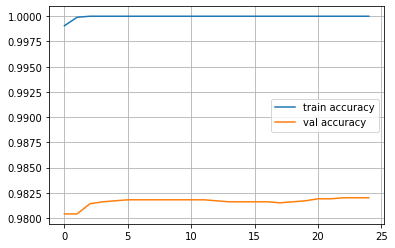

Total time: 281.7999629974365 seconds

Training accuracy list: [0.99906 0.9999  1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.      1.      1.     ]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


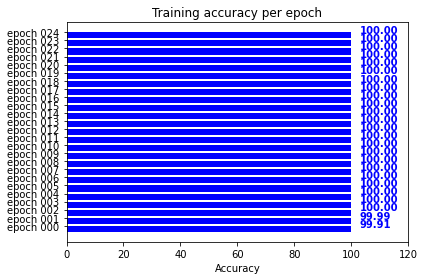


Validation accuracy list: [0.9804 0.9804 0.9814 0.9816 0.9817 0.9818 0.9818 0.9818 0.9818 0.9818
 0.9818 0.9818 0.9817 0.9816 0.9816 0.9816 0.9816 0.9815 0.9816 0.9817
 0.9819 0.9819 0.982  0.982  0.982 ]
Validation accuracy (Mean +/- Std): 98.16 (+/- 0.00)


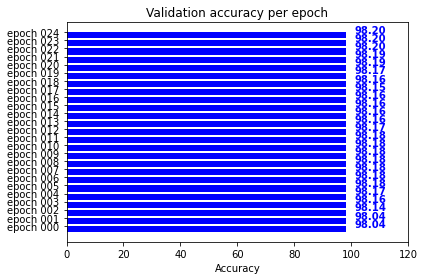


Epoch time list: [ 10.778332    21.66193414  32.5110817   43.564044    54.32025576
  65.05434799  75.93726563  86.65293455  97.4889636  108.22369361
 119.49831271 130.9287684  142.44689727 153.51477671 164.79156828
 175.86049891 187.25496054 198.22121835 209.64481831 220.90831017
 231.74965477 242.76239491 253.68813419 270.69409585 281.59015918]
Epoch time (Mean +/- Std): 143.19 (+/- 161.33)


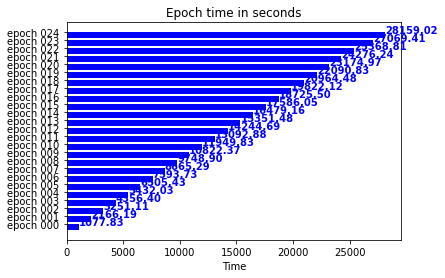

In [35]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=16, shuffle=True)

### Using 3 dense layers with learning_rate = 0.001. Minibatches: **batchsize=32**, shuffle=True

Epoch 24
Training accuracy: 100.00%
Validation accuracy: 98.19%
Epoch's processing time: 199.59 seconds


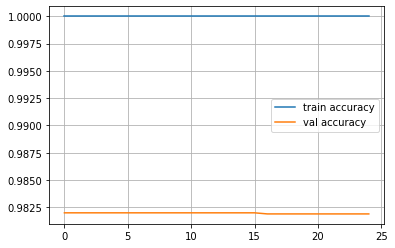

Total time: 199.8012216091156 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


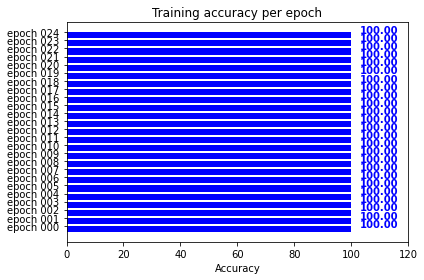


Validation accuracy list: [0.982  0.982  0.982  0.982  0.982  0.982  0.982  0.982  0.982  0.982
 0.982  0.982  0.982  0.982  0.982  0.982  0.9819 0.9819 0.9819 0.9819
 0.9819 0.9819 0.9819 0.9819 0.9819]
Validation accuracy (Mean +/- Std): 98.20 (+/- 0.00)


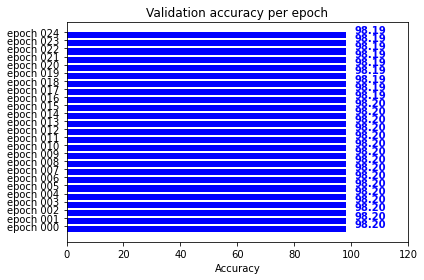


Epoch time list: [  7.57613015  15.48511147  23.67529416  31.64115143  39.85248899
  48.2626574   56.30119729  64.34935737  72.50162768  80.80360055
  88.74693179  96.56092095 104.73581457 112.6276207  120.47184634
 128.34381843 136.20358944 144.05841041 151.72062111 159.46257758
 167.57105422 175.62477684 183.62497163 191.54655433 199.58839583]
Epoch time (Mean +/- Std): 104.05 (+/- 115.21)


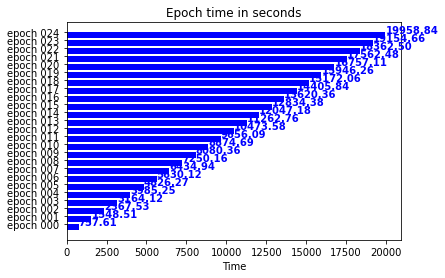

In [36]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 3 dense layers with learning_rate = 0.001. Minibatches: **batchsize=64**, shuffle=True

Epoch 24
Training accuracy: 100.00%
Validation accuracy: 98.20%
Epoch's processing time: 152.59 seconds


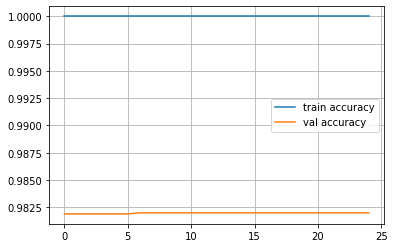

Total time: 152.79025506973267 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


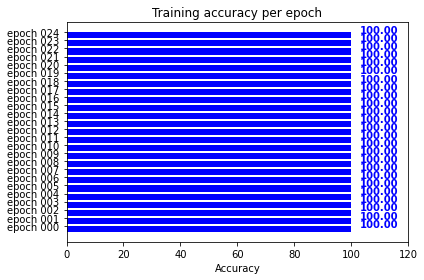


Validation accuracy list: [0.9819 0.9819 0.9819 0.9819 0.9819 0.9819 0.982  0.982  0.982  0.982
 0.982  0.982  0.982  0.982  0.982  0.982  0.982  0.982  0.982  0.982
 0.982  0.982  0.982  0.982  0.982 ]
Validation accuracy (Mean +/- Std): 98.20 (+/- 0.00)


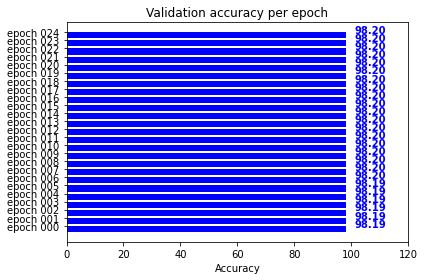


Epoch time list: [  5.83100533  11.95681262  17.92046833  23.89125133  30.00980306
  36.05457401  42.0358057   48.01110315  53.94400764  59.89735532
  65.95623517  72.1422925   78.23146605  84.48922515  90.65214133
  96.9487083  103.15812373 109.3483355  115.53952241 121.68185091
 127.90732265 134.04380822 140.25645471 146.43645144 152.5851469 ]
Epoch time (Mean +/- Std): 78.76 (+/- 88.26)


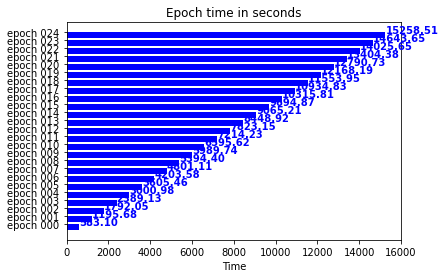

In [37]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=64, shuffle=True)

### Using 3 dense layers with learning_rate = 0.001. Minibatches: **batchsize=128**, shuffle=True

Epoch 24
Training accuracy: 100.00%
Validation accuracy: 98.20%
Epoch's processing time: 132.39 seconds


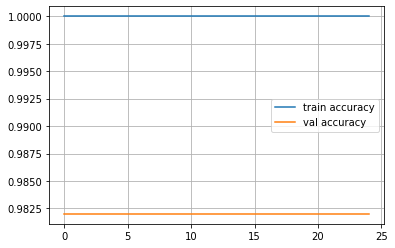

Total time: 132.59663105010986 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


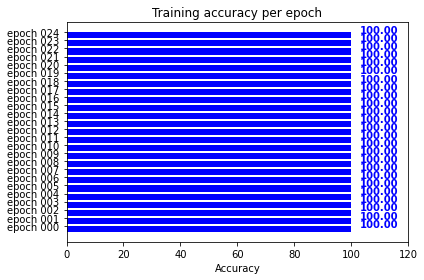


Validation accuracy list: [0.982 0.982 0.982 0.982 0.982 0.982 0.982 0.982 0.982 0.982 0.982 0.982
 0.982 0.982 0.982 0.982 0.982 0.982 0.982 0.982 0.982 0.982 0.982 0.982
 0.982]
Validation accuracy (Mean +/- Std): 98.20 (+/- 0.00)


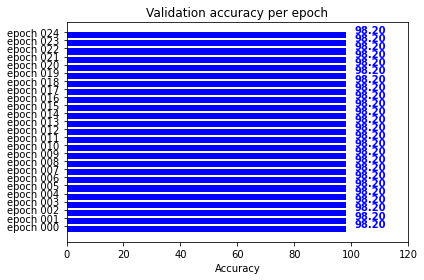


Epoch time list: [  5.08323669  10.24086928  15.62061238  20.9398098   26.26584673
  31.52816749  36.66813612  41.77723145  47.19986892  52.61085606
  57.9348948   63.24397302  68.41687536  73.90459609  79.13940215
  84.44365311  89.86777973  95.14874625 100.38378692 105.7188189
 111.04047108 116.40733075 121.7196238  127.03822899 132.39183211]
Epoch time (Mean +/- Std): 68.59 (+/- 76.53)


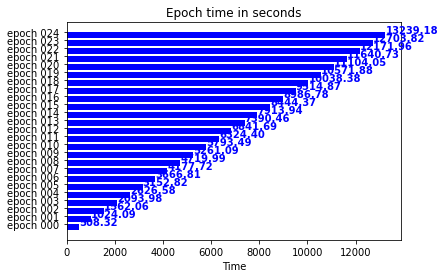

In [38]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=128, shuffle=True)

## Best batch size

* Highest validation accuracy (mean)

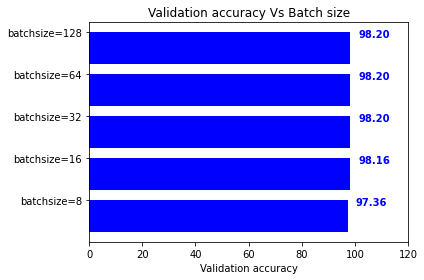

In [39]:
labels = ['batchsize=8', 'batchsize=16', 'batchsize=32', 'batchsize=64', 'batchsize=128']
plot_horizontal_bar(labels, validation_accuracy_list, xlabel='Validation accuracy', ylabel='', title='Validation accuracy Vs Batch size', use_xlim=True)

## Conclusion: Best MLP model

### Using 3 dense layers with learning_rate = 0.001. Minibatches: batchsize=32, shuffle=True

In [42]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		ReLU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		ReLU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		ReLU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 100.00%
Validation accuracy: 98.29%
Epoch's processing time: 209.41 seconds


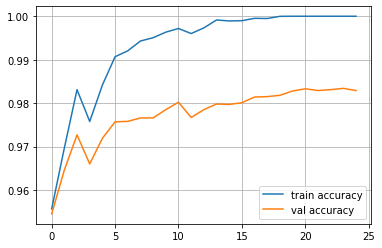

Total time: 209.59721302986145 seconds

Training accuracy list: [0.95564 0.96968 0.9831  0.97578 0.98416 0.99068 0.99204 0.9943  0.99506
 0.99634 0.99718 0.99602 0.99732 0.99914 0.99892 0.99898 0.99952 0.99948
 0.99998 1.      1.      1.      1.      1.      1.     ]
Training accuracy (Mean +/- Std): 99.29 (+/- 0.02)


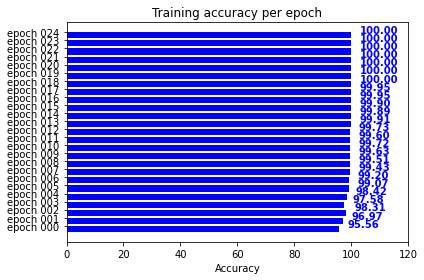


Validation accuracy list: [0.9545 0.9646 0.9727 0.966  0.9719 0.9757 0.9758 0.9766 0.9766 0.9785
 0.9802 0.9767 0.9785 0.9798 0.9797 0.9801 0.9814 0.9815 0.9818 0.9828
 0.9833 0.9829 0.9831 0.9834 0.9829]
Validation accuracy (Mean +/- Std): 97.72 (+/- 0.01)


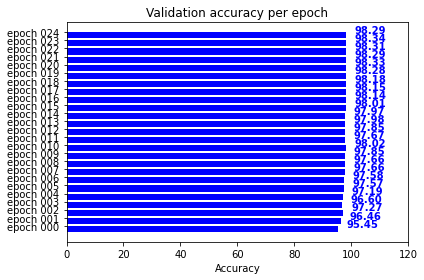


Epoch time list: [  8.20587468  16.62421107  25.07650185  33.47661185  41.83071733
  50.37279987  58.73314071  67.2285459   75.65193748  84.11100578
  92.57738829 100.86090755 109.37306738 117.82402515 126.25824642
 134.68010139 143.06382346 151.43364239 159.75209069 168.23175144
 176.63463306 184.77745509 192.86571813 201.10058355 209.41169119]
Epoch time (Mean +/- Std): 109.21 (+/- 121.14)


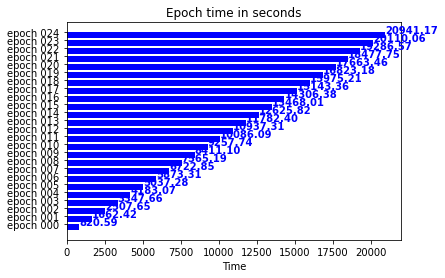

In [43]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)